In [15]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import urllib

In [16]:
raw_sample = pd.read_csv('combined-20160401-sample.csv')
next_day = pd.read_csv('full-actual-edits-20160402.csv', sep=',', keep_default_na=False, na_values=[''])
next_day = next_day[next_day['page_namespace'] == 0]
next_day['page_title'] = next_day['page_title'].apply(urllib.parse.quote)

In [17]:
print(raw_sample.shape)
print(next_day.shape)
sample = pd.merge(
    raw_sample,
    next_day,
    how='left',
    left_on=['Article Name'],
    right_on=['page_title'],
    suffixes=('', '_next_day')
)
print(sample.shape)

(30697, 22)
(66277, 5)
(30697, 27)


In [18]:
sample['edits_next_day'] = sample['edits_next_day'].replace(-1, float('nan'))
sample['edits_next_day'] = sample['edits_next_day'].fillna(value=0)
set(sample['edits_next_day'])

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0, 18.0}

In [19]:
sample.head()

,Unnamed: 0,Article Name,view_count,size,min_size,max_size,Article Namespace,page_namespace,page_title,date,...,page_namespace_talk,page_title_talk,date_talk,edits_talk,minor_edits_talk,page_namespace_next_day,page_title_next_day,date_next_day,edits_next_day,minor_edits_next_day
0,10172120,Larry_Cowart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20160401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,1560864,Third_Tunnel_of_Aggression,65.0,33876.0,12175.0,85241.0,0.0,NaN,NaN,20160401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,1418946,Slow_left-arm_orthodox,26.0,20744.0,10595.0,60009.0,0.0,NaN,NaN,20160401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,9531354,LONDON_PHILHARMONIC_ORCHESTRA_%28band%29,1.0,25800.0,25800.0,25800.0,0.0,NaN,NaN,20160401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,4190747,The_Leaf-Chronicle,14.0,19250.0,0.0,61181.0,0.0,NaN,NaN,20160401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [20]:
result = smf.ols(formula = "edits_next_day ~ view_count + size", data = sample).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         edits_next_day   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     268.2
Date:                Mon, 06 Nov 2017   Prob (F-statistic):          3.51e-116
Time:                        21:51:54   Log-Likelihood:                 9301.6
No. Observations:               30305   AIC:                        -1.860e+04
Df Residuals:                   30302   BIC:                        -1.857e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0064      0.001      6.183      0.0

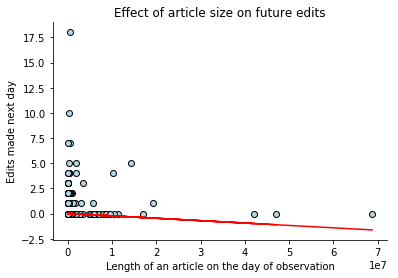

In [24]:
# effect of size controlling for view_count

sorted_size = np.asarray(sorted(sample['size']))
plt.figure()
plt.scatter(sample['size'], sample['edits_next_day'], edgecolor='black', color='lightblue')
plt.ylabel('Edits made next day')
plt.xlabel('Length of an article on the day of observation')
plt.title('Effect of article size on future edits')
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

linear = plt.plot(
    sorted_size, 
    0.0064 + -2.372e-08*sorted_size, 
    color='r')


# plt.xlim(0, 15000000)


plt.show()

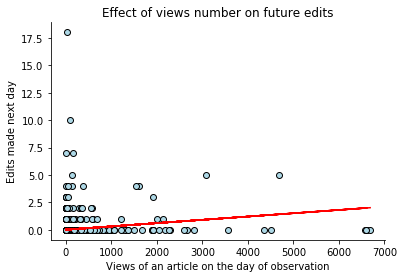

In [27]:
# effect of view_count controlling for size

sorted_view_count = np.asarray(sorted(sample['view_count']))

plt.scatter(sample['view_count'], sample['edits_next_day'], edgecolor='black', color='lightblue')

linear = plt.plot(
    sorted_view_count, 
    0.0064 + 0.0003*sorted_view_count, 
    color='r')

# plt.xlim(0, 10000)
plt.ylabel('Edits made next day')
plt.xlabel('Views of an article on the day of observation')
plt.title('Effect of views number on future edits')
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [21]:
result = smf.ols(formula = "edits_next_day ~ edits + view_count + size + edits_talk + view_count_talk + size_talk", data = sample).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         edits_next_day   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     137.4
Date:                Mon, 06 Nov 2017   Prob (F-statistic):           5.41e-11
Time:                        18:17:49   Log-Likelihood:                 10.348
No. Observations:                  20   AIC:                            -6.696
Df Residuals:                      13   BIC:                            0.2737
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.7035      0.324     

In [22]:
sample['edits_binary_next_day'] = sample['edits_next_day'].apply(lambda x: int(x > 0))
set(sample['edits_binary_next_day'])

{0, 1}

In [23]:
sample.head()

,Unnamed: 0,Article Name,view_count,size,min_size,max_size,Article Namespace,page_namespace,page_title,date,...,page_title_talk,date_talk,edits_talk,minor_edits_talk,page_namespace_next_day,page_title_next_day,date_next_day,edits_next_day,minor_edits_next_day,edits_binary_next_day
0,10172120,Larry_Cowart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20160401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
1,1560864,Third_Tunnel_of_Aggression,65.0,33876.0,12175.0,85241.0,0.0,NaN,NaN,20160401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
2,1418946,Slow_left-arm_orthodox,26.0,20744.0,10595.0,60009.0,0.0,NaN,NaN,20160401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
3,9531354,LONDON_PHILHARMONIC_ORCHESTRA_%28band%29,1.0,25800.0,25800.0,25800.0,0.0,NaN,NaN,20160401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
4,4190747,The_Leaf-Chronicle,14.0,19250.0,0.0,61181.0,0.0,NaN,NaN,20160401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0


In [25]:
result2 = smf.logit(formula = "edits_binary_next_day ~ edits + view_count + size + view_count_talk + size_talk", data = sample).fit()
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.098663
         Iterations 8
                             Logit Regression Results                            
Dep. Variable:     edits_binary_next_day   No. Observations:                 2588
Model:                             Logit   Df Residuals:                     2582
Method:                              MLE   Df Model:                            5
Date:                   Mon, 06 Nov 2017   Pseudo R-squ.:                 0.09263
Time:                           18:21:12   Log-Likelihood:                -255.34
converged:                          True   LL-Null:                       -281.41
                                           LLR p-value:                 5.066e-10
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.2620      0.192    -22.164      0.000      -4.639   

In [26]:
for feature in ['view_count', 'view_count_talk', 
                'size', 'min_size', 'max_size', 'size_talk', 'min_size_talk', 'max_size_talk',
                'edits', 'minor_edits', 'edits_talk', 'minor_edits_talk']:
    print("min of " + str(feature) + ": " + str(min(sample[feature][~np.isnan(sample[feature])])))
    print("max of " + str(feature) + ": " + str(max(sample[feature][~np.isnan(sample[feature])])))
    print("mean of " + str(feature) + ": " + str(np.mean(sample[feature][~np.isnan(sample[feature])])))
    print("median of " + str(feature) + ": " + str(np.median(sample[feature][~np.isnan(sample[feature])])))
    print("SD of " + str(feature) + ": " + str(np.std(sample[feature][~np.isnan(sample[feature])])))
    print("\n")

min of view_count: 1.0
max of view_count: 6688.0
mean of view_count: 14.274905131166474
median of view_count: 2.0
SD of view_count: 116.56569401756404


min of view_count_talk: 1.0
max of view_count_talk: 110.0
mean of view_count_talk: 1.334228187919463
median of view_count_talk: 1.0
SD of view_count_talk: 2.2845489711585345


min of size: 0.0
max of size: 68779248.0
mean of size: 45416.138590991584
median of size: 15735.0
SD of size: 601975.0461647075


min of min_size: 0.0
max of min_size: 63595712.0
mean of min_size: 25541.96231644943
median of min_size: 11317.0
SD of min_size: 429909.73395670933


min of max_size: 0.0
max of max_size: 228428216.0
mean of max_size: 113413.74858934169
median of max_size: 20418.0
SD of max_size: 2153994.0542353084


min of size_talk: 0.0
max of size_talk: 506984.0
mean of size_talk: 15973.031543624162
median of size_talk: 9854.0
SD of size_talk: 21044.506278290093


min of min_size_talk: 0.0
max of min_size_talk: 506984.0
mean of min_size_talk: 14507.